# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [1]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
sns.set()
plt.style.use('fivethirtyeight')

In [2]:
titanic = sns.load_dataset('titanic')

titanic.describe(include='all')
df = titanic.drop('deck',axis=1) # drop deck as it has significant amount of missing data 688 NaN/891
df = df.dropna()
df['adult_male'] = pd.get_dummies(df['adult_male'], drop_first=False)

print(sm.OLS(
    (df['survived']),
    sm.add_constant(
        df[['age']].join(
            [(pd.get_dummies(df['sex'], drop_first=True)),
             (pd.get_dummies(df['class'], drop_first=True))])
        )
    ).fit(cov_type='HC2').summary())

                            OLS Regression Results                            
Dep. Variable:               survived   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     174.0
Date:                Mon, 08 Feb 2021   Prob (F-statistic):          1.05e-103
Time:                        19:17:26   Log-Likelihood:                -328.74
No. Observations:                 712   AIC:                             667.5
Df Residuals:                     707   BIC:                             690.3
Df Model:                           4                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1245      0.049     22.851      0.0

In [3]:
print(sm.Logit(
    (df['survived']),
    sm.add_constant(
        df[['age']].join(
            [(pd.get_dummies(df['sex'], drop_first=True)),
             (pd.get_dummies(df['class'], drop_first=True))])
        )
    ).fit(cov_type='HC2').summary())

Optimization terminated successfully.
         Current function value: 0.454137
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      707
Method:                           MLE   Df Model:                            4
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:                  0.3270
Time:                        19:17:26   Log-Likelihood:                -323.35
converged:                       True   LL-Null:                       -480.45
Covariance Type:                  HC2   LLR p-value:                 9.300e-67
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7692      0.421      8.960      0.000       2.945       4.594
age           -0.0372      0.

In [4]:
# y_pred_lr = est.predict(X_test)
# y_pred_lr = np.round(y_pred_lr)

# print(confusion_matrix(y_test, y_pred_lr))
# print(classification_report(y_test, y_pred_lr))

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

y = df['survived']
X = sm.add_constant(
        df[['age']].join(
            [(pd.get_dummies(df['sex'], drop_first=True)),
             (pd.get_dummies(df['class'], drop_first=True))]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[102  23]
 [ 24  65]]


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       125
           1       0.74      0.73      0.73        89

    accuracy                           0.78       214
   macro avg       0.77      0.77      0.77       214
weighted avg       0.78      0.78      0.78       214



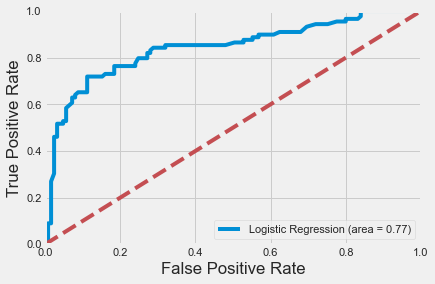

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### How much better is logistic regression than OLS on binary data?
    
    Although the linear regression had statistically significant predictors, it proved to be a poor method to model the survival probability with an R-squared value of 0.388.
    The poor R-squared value indicates that the model did not capture the variability of the response data.
    This was improved however with a logistic regression. This is especially evident in the ROC curve that is indicating a greater coverage for True Positive rate, with an area of 0.77.
    This is reflecting the precision of the model to 0.77.

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [10]:
# ref : https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/

from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

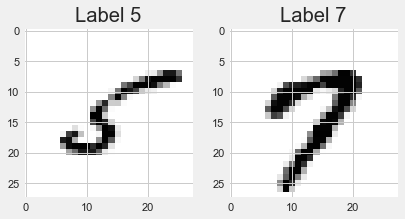

In [11]:
# Show two example images
fig, ax = plt.subplots(1,2)
ax[0].imshow(X[11,:].reshape(28,28), 'Greys')
ax[1].imshow(X[15,:].reshape(28,28), 'Greys')
ax[0].set_title("Label 5")
ax[1].set_title("Label 7")
plt.show()

In [12]:
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(10_000/X.shape[0]), random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200)) # increased max_iter
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

C:\Users\gayar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9157

# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [31]:
fish = pd.read_csv('data/fish.csv')
fish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   LIVE_BAIT   250 non-null    int64
 1   CAMPER      250 non-null    int64
 2   PERSONS     250 non-null    int64
 3   CHILDREN    250 non-null    int64
 4   FISH_COUNT  250 non-null    int64
dtypes: int64(5)
memory usage: 9.9 KB


In [32]:
fish.describe()

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
count,250.000000,250.000000,250.00000,250.000000,250.000000
mean,0.864000,0.588000,2.52800,0.684000,3.296000
std,0.343476,0.493182,1.11273,0.850315,11.635028
min,0.000000,0.000000,1.00000,0.000000,0.000000
25%,1.000000,0.000000,2.00000,0.000000,0.000000
50%,1.000000,1.000000,2.00000,0.000000,0.000000
75%,1.000000,1.000000,4.00000,1.000000,2.000000
max,1.000000,1.000000,4.00000,3.000000,149.000000


In [33]:
fish['FISH_COUNT'].describe()

count    250.000000
mean       3.296000
std       11.635028
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max      149.000000
Name: FISH_COUNT, dtype: float64

In [34]:
fish = fish.drop(fish['FISH_COUNT'].idxmax()).reset_index(drop=True) # drop outlier data point

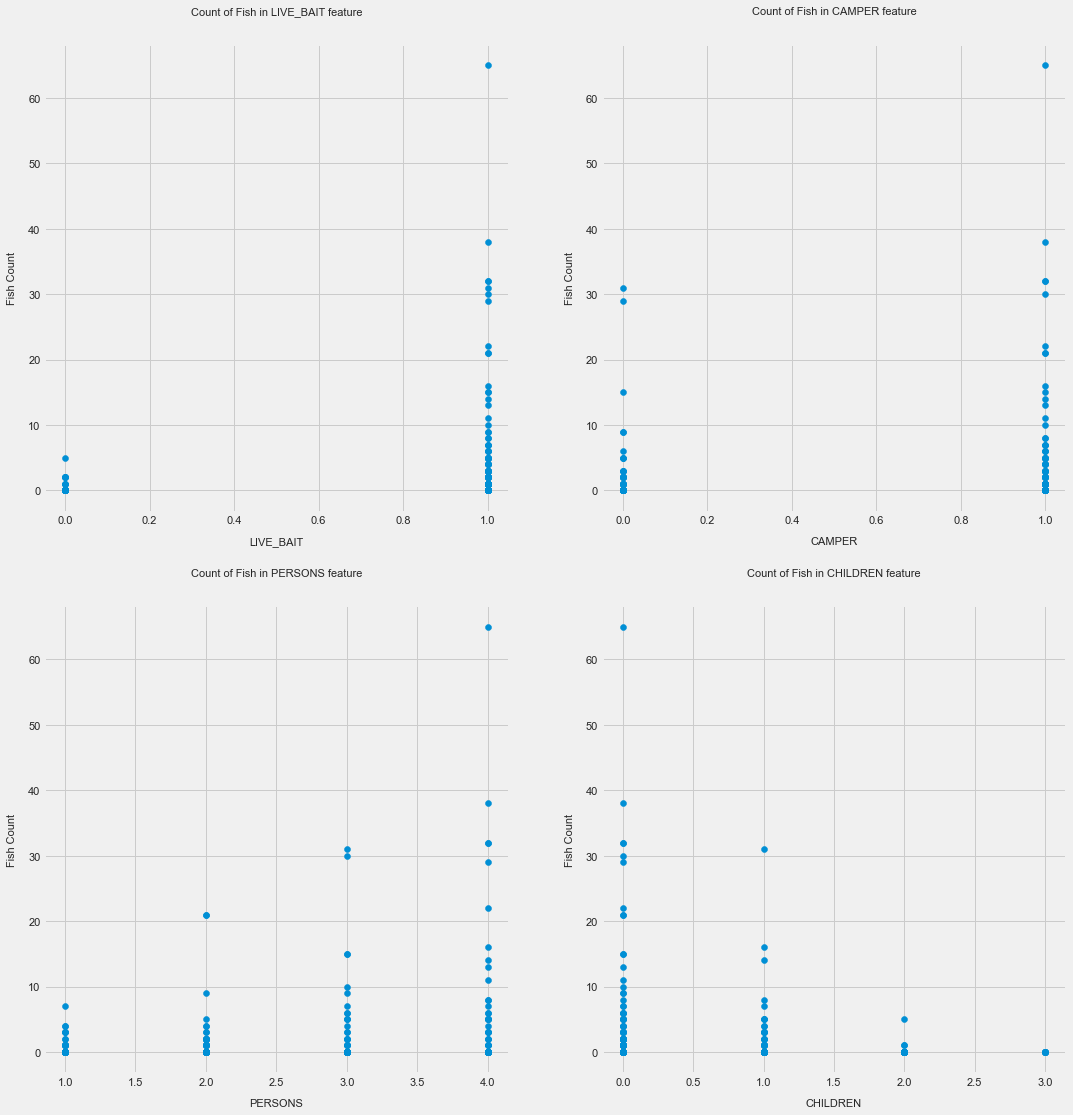

In [35]:
cat_features = ['LIVE_BAIT','CAMPER','PERSONS','CHILDREN']

fig, axs = plt.subplots(figsize=(10, 10))
plt.subplots_adjust(right=1.5, top=1.5)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 2, i)
    plt.scatter(x=feature, y='FISH_COUNT', data=fish)
    
    plt.xlabel('{}'.format(feature), size=11, labelpad=11)
    plt.ylabel('Fish Count', size=11, labelpad=11)    
    plt.tick_params(axis='x', labelsize=11)
    plt.tick_params(axis='y', labelsize=11)
    
    plt.title('Count of Fish in {} feature'.format(feature), size=11, y=1.05)

plt.show()

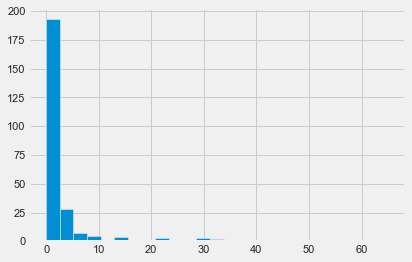

In [36]:
fish['FISH_COUNT'].hist(bins=25)

In [38]:
LIVE_BAIT = pd.get_dummies(fish['LIVE_BAIT'], drop_first=True)
LIVE_BAIT.columns = ['LIVE_BAIT_YES']

CAMPER = pd.get_dummies(fish['CAMPER'], drop_first=True)
CAMPER.columns = ['CAMPER_YES']

In [40]:
# Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

x = fish[['PERSONS','CHILDREN']].join([LIVE_BAIT]) # CAMPER not included due to poor P value
y = fish['FISH_COUNT']

print(sm.Poisson(y, sm.add_constant(x)).fit(cov_type='HC2').summary())

Optimization terminated successfully.
         Current function value: 2.699728
         Iterations 8
                          Poisson Regression Results                          
Dep. Variable:             FISH_COUNT   No. Observations:                  249
Model:                        Poisson   Df Residuals:                      245
Method:                           MLE   Df Model:                            3
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:                  0.4437
Time:                        19:34:13   Log-Likelihood:                -672.23
converged:                       True   LL-Null:                       -1208.3
Covariance Type:                  HC2   LLR p-value:                3.847e-232
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.6674      0.461     -5.790      0.000      -3.570      -1.765
PERSONS           0.

In [41]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

print(sm.ZeroInflatedPoisson(y, sm.add_constant(x)).fit(cov_type='HC2').summary())

Optimization terminated successfully.
         Current function value: 2.398149
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:              FISH_COUNT   No. Observations:                  249
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            3
Date:                 Mon, 08 Feb 2021   Pseudo R-squ.:                  0.2611
Time:                         19:34:16   Log-Likelihood:                -597.14
converged:                        True   LL-Null:                       -808.16
Covariance Type:                   HC2   LLR p-value:                 3.731e-91
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.1771

In [42]:
# Two Stage Modelling

y = fish['FISH_COUNT']
# Stage 1
est1 = sm.Logit((y > 0).astype(int), sm.add_constant(x)).fit(cov_type='HC2')

# Prep Stage 2
X = pd.DataFrame(sm.add_constant(x))
X['stage1'] = est1.predict(X)
X['stage1_sqrd'] = X['stage1'] **2
X.columns = ['const', 'LIVE_BAIT', 'PERSONS','CHILDREN','stage1','stage1_sqrd']

# Stage 2
est2 = sm.Poisson(y, X).fit(cov_type='HC2')
print(est2.summary())

Optimization terminated successfully.
         Current function value: 0.514929
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.688689
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:             FISH_COUNT   No. Observations:                  249
Model:                        Poisson   Df Residuals:                      243
Method:                           MLE   Df Model:                            5
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:                  0.4460
Time:                        19:34:18   Log-Likelihood:                -669.48
converged:                       True   LL-Null:                       -1208.3
Covariance Type:                  HC2   LLR p-value:                8.888e-231
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
cons

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

In [23]:
# ref: https://github.com/anurag-code/Survival-Analysis-Intuition-Implementation-in-Python/blob/master/Survival%20Analysis%20-%20Quick%20Implementation.ipynb

In [24]:
df = pd.read_csv('data/telco_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [26]:
## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [27]:
## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

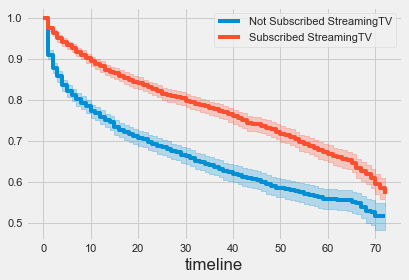

In [28]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter() 

T = df['tenure']     
E = df['Churn']


## Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = df['StreamingTV']   
i1 = (groups == 'No')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Yes')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf.plot()

## fit the model for 2nd cohort
kmf.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf.plot(ax=a1)

In [29]:
from lifelines.datasets import load_regression_dataset
df = load_regression_dataset()

from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df, 'T', event_col='E')
print(cph.print_summary())

<lifelines.CoxPHFitter: fitted with 200 total observations, 11 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 189
   partial log-likelihood = -807.62
         time fit was run = 2021-02-09 00:18:28 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
var1        0.22       1.25       0.07             0.08             0.37                 1.08                 1.44
var2        0.05       1.05       0.08            -0.11             0.21                 0.89                 1.24
var3        0.22       1.24       0.08             0.07             0.37                 1.07                 1.44

             z      p   -log2(p)
covariate                       
var1      2.99 <0.005       8.49
var2      0.61   0.54       0.89
var3      2.88 <0.005       7.97
---
Concordance = 0.58
Partial AIC = 1621.24
log-likelihood ratio test = 15.54 on 3 df
-log2(p) of ll-ratio test = 9.47

None


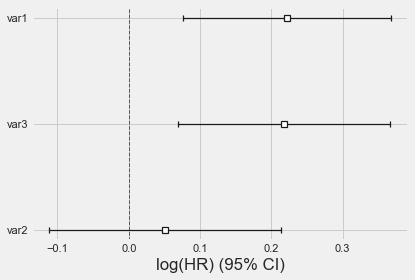

In [30]:
cph.plot()